In [67]:
import pandas as pd

df = pd.read_csv('final_df')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   crop_type              526 non-null    object 
 1   crop_season            526 non-null    object 
 2   species_mix            526 non-null    object 
 3   biomass_seed           526 non-null    float64
 4   plant_density          526 non-null    float64
 5   density_relative       526 non-null    float64
 6   density_factor         526 non-null    object 
 7   n_amount               526 non-null    int64  
 8   cultivar_mix           526 non-null    object 
 9   interrow               526 non-null    float64
 10  mixing_pattern         526 non-null    object 
 11  mixture_design         526 non-null    object 
 12  n_fertilisation_type   526 non-null    object 
 13  n_fertiliser           526 non-null    object 
 14  irrigation_amount      526 non-null    float64
 15  p_amou

TODO:
- validate objects
- use trees to get feature importances
- train models
- reuse shap for tree-based models(?)
- maybe implement bayesian optimization if may time pa

# Data Preprocessing

In [69]:
# segregate columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop('biomass_seed', axis=1).columns

# tolower categorical columns
for col in categorical_columns:
  df[col] = df[col].str.lower()

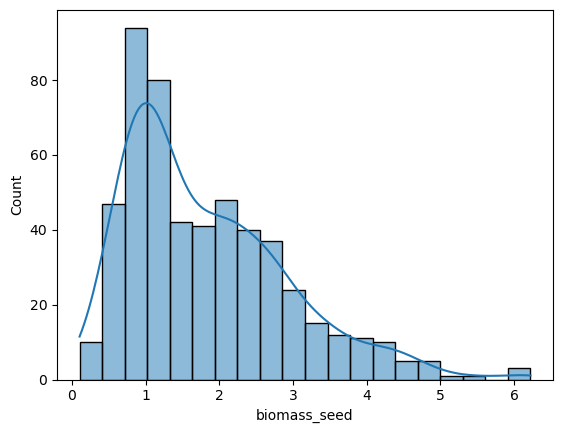

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# view target value distribution
sns.histplot(df['biomass_seed'], bins=20, kde=True)
plt.show()

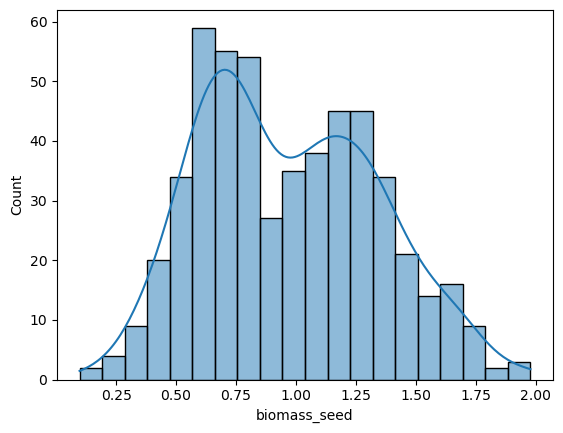

In [71]:
import numpy as np

# log transform + 1 target variable to fix skewed distribution
y = np.log1p(df['biomass_seed'])
sns.histplot(y, bins=20, kde=True)
plt.show()

In [72]:
# see unique values for categorical variables
for col in categorical_columns:
  print(col)
  print(df[col].unique())
  print('\n')

crop_type
['ic']


crop_season
['spring' 'winter']


species_mix
['barley_pea' 'wheat_aestivum_pea' 'wheat_turgidum_fababean'
 'wheat_turgidum_pea' 'wheat_aestivum_lentil' 'wheat_turgidum_chickpea'
 'barley_fababean' 'barley_lupin']


density_factor
['0.33_1' '0.5_0.5' '0.5_1' '0.3_0.7' '0.7_0.3' '0.33_1.3' '0.33_0.7'
 '0.17_1.3' '0.17_1' '0.67_0.5' '0.67_1' '0.33_0.5' '0.33_0.66' '0.7_0.5'
 '0.15_1' '0.05_1']


cultivar_mix
['scarlett_baccara' 'cezanne_lucy' 'apache_lucy' 'l1823_irena'
 'acalou_lucy' 'nefer_lucy' 'neodur_lucy' 'orjaune_lucy' 'l1823_aoph10'
 'l1823_geronimo' 'l1823_isard' 'l1823_kazar' 'l1823_lucy' 'nefer_aoph10'
 'nefer_geronimo' 'sculptur_aoph10' 'sculptur_geronimo' 'sculptur_isard'
 'sculptur_kazar' 'sculptur_lucy' 'l1823_castel' 'l1823_diver'
 'l1823_nordica' 'nefer_castel' 'nefer_irena' 'sculptur_castel'
 'sculptur_diver' 'sculptur_irena' 'sculptur_nordica' 'togano_anicia'
 'togano_beluga' 'togano_flora' 'togano_rosana' 'valbona_anicia'
 'valbona_beluga' 'valbona_

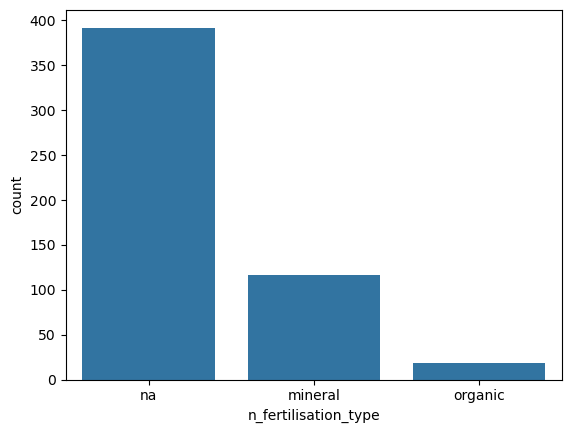

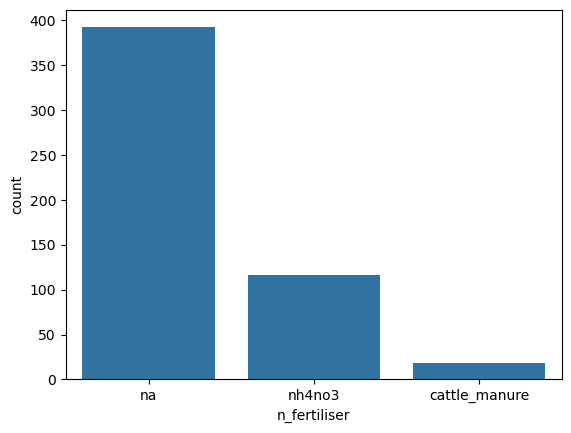

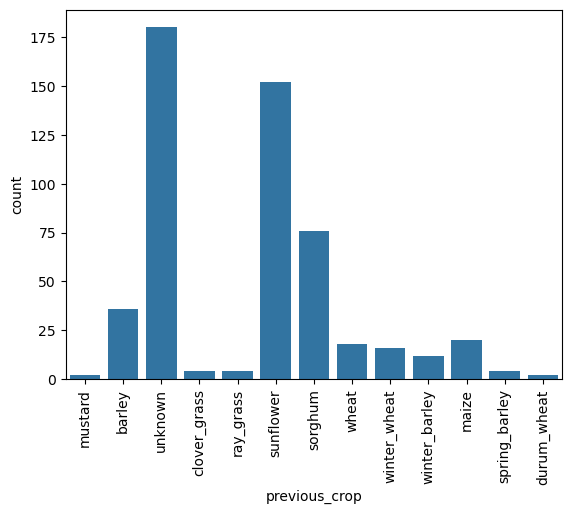

In [73]:
# see count of n_fertilisation_type, n_fertiliser, and previous_crop
sns.countplot(x='n_fertilisation_type', data=df)
plt.show()
sns.countplot(x='n_fertiliser', data=df)
plt.show()
sns.countplot(x='previous_crop', data=df)
plt.xticks(rotation=90)
plt.show()

Since they're mostly null values, I will exclude them from the data.

In [74]:
drop_nulls = ['n_fertilisation_type', 'n_fertiliser', 'previous_crop']
df.drop(drop_nulls, axis=1, inplace=True, errors='ignore')
# remove the dropped colmns from categorical_columns
categorical_columns = [col for col in categorical_columns if col not in drop_nulls]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   crop_type              526 non-null    object 
 1   crop_season            526 non-null    object 
 2   species_mix            526 non-null    object 
 3   biomass_seed           526 non-null    float64
 4   plant_density          526 non-null    float64
 5   density_relative       526 non-null    float64
 6   density_factor         526 non-null    object 
 7   n_amount               526 non-null    int64  
 8   cultivar_mix           526 non-null    object 
 9   interrow               526 non-null    float64
 10  mixing_pattern         526 non-null    object 
 11  mixture_design         526 non-null    object 
 12  irrigation_amount      526 non-null    float64
 13  p_amount               526 non-null    int64  
 14  pest_control           526 non-null    object 
 15  countr

In [75]:
drop_decisions = ['country', 'site', 'plot_name']
df.drop(drop_decisions, axis=1, inplace=True, errors='ignore')

## EDA

In [76]:
# get correlation of numerical columns with plant_density
correlation_with_plant_density = df[numerical_columns].corrwith(df['plant_density']).sort_values(ascending=False)
print(correlation_with_plant_density);

plant_density            1.000000
density_relative         0.564370
total_solar_radiation    0.274857
soil_ph                  0.241286
heat_stress_days         0.228588
interrow                 0.220082
soil_sand                0.125904
stress_index             0.112320
density_error            0.095626
soil_awc                 0.092099
total_precipitation      0.071888
soil_clay                0.065280
crowding                -0.065677
p_amount                -0.093507
plot_long               -0.108336
irrigation_amount       -0.129034
n_amount                -0.184214
soil_silt               -0.236043
GDD                     -0.270766
soil_water_capacity     -0.289956
high_humidity_days      -0.299301
nitrogen_residual       -0.371404
growing_days            -0.428943
density_n_ratio               NaN
dtype: float64


/home/kabs/miniconda3/envs/mulreg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [77]:
df.describe()

/home/kabs/miniconda3/envs/mulreg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,biomass_seed,plant_density,density_relative,n_amount,interrow,irrigation_amount,p_amount,plot_long,soil_awc,soil_clay,soil_sand,soil_silt,soil_ph,nitrogen_residual,heat_stress_days,total_precipitation,total_solar_radiation,high_humidity_days,growing_days,density_error,density_n_ratio,crowding,soil_water_capacity,GDD,stress_index
count,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000
mean,1.827832,114.139359,0.556578,22.733840,0.156536,3.676806,5.186312,2.421117,285.430064,0.223759,0.461141,0.338606,7.285272,43.029771,52.140684,1511.567338,9593.167985,379.501901,188.334601,-8.090679,inf,0.074144,-0.223308,1946.026100,0.540663
std,1.106310,86.764848,0.220641,44.145533,0.014730,15.550291,17.593924,3.436047,27.706269,0.089419,0.234394,0.172555,0.906364,20.135828,34.355331,132.374561,1073.129473,118.029468,59.609413,25.862916,NaN,0.262255,0.366636,783.152270,0.090637
min,0.102500,10.288066,0.050000,0.000000,0.120000,0.000000,0.000000,-1.550000,70.000000,0.040000,0.026000,0.040000,5.500000,19.000000,0.000000,1255.580000,6893.250000,273.000000,83.000000,-83.838384,0.083284,0.000000,-0.577789,594.488304,0.365735
25%,0.949099,38.822751,0.500000,0.000000,0.145000,0.000000,0.000000,1.496384,291.500000,0.181875,0.280000,0.225151,6.800000,31.227477,15.750000,1401.490000,9015.770000,289.000000,123.000000,-17.303942,4.280472,0.000000,-0.521055,1393.206566,0.452234
50%,1.550109,103.926200,0.500000,0.000000,0.162000,0.000000,0.000000,1.501086,291.500000,0.240000,0.461000,0.300000,7.393333,41.000000,63.000000,1532.130000,10190.420000,336.000000,232.000000,-4.725248,NaN,0.000000,-0.374000,1888.098447,0.516487
75%,2.473669,149.408144,0.500000,30.000000,0.165000,0.000000,0.000000,1.503090,291.500000,0.260000,0.540000,0.421450,7.900000,42.000000,81.000000,1590.930000,10345.180000,459.000000,244.000000,2.471451,NaN,0.000000,0.230312,2771.943211,0.620970
max,6.221384,409.090909,1.300000,180.000000,0.180000,105.000000,66.000000,16.120100,333.000000,0.420000,1.000000,0.801500,8.460000,100.323003,105.000000,2123.880000,11463.440000,649.000000,256.000000,246.969697,inf,1.000000,0.362050,2940.977404,0.758860


It shows inf and NaN values on density_n_ratio, as such, it is necessary to handle them before training.

In [78]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

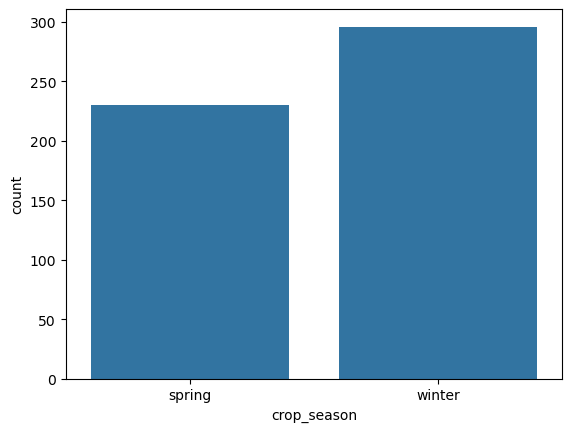

In [79]:
# count of winter and summer crops
sns.countplot(x='crop_season', data=df)
plt.show()

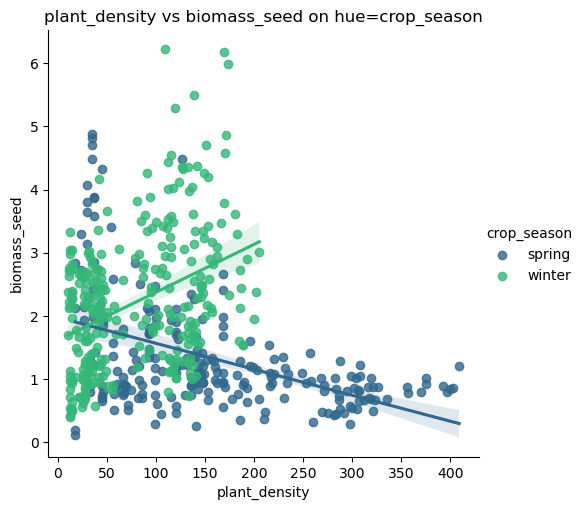

In [80]:
# see biomass_seed vs plant_density on hue=crop_season
sns.lmplot(x='plant_density', y='biomass_seed', hue='crop_season', data=df, palette='viridis')
plt.title('plant_density vs biomass_seed on hue=crop_season')
plt.show()

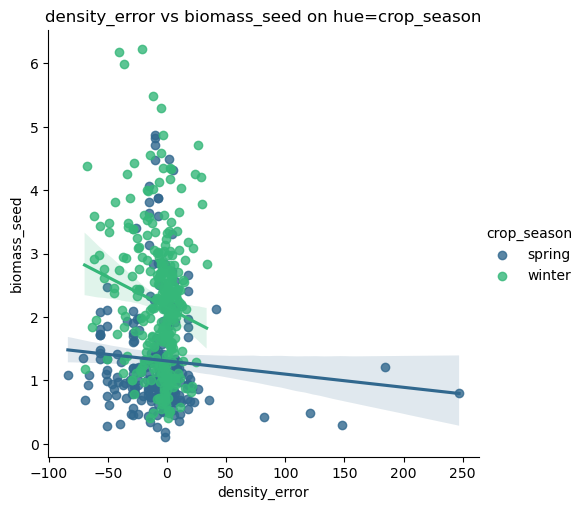

In [81]:
# see how density error behaves against yield on hue=crop_season
sns.lmplot(x='density_error', y='biomass_seed', hue='crop_season', data=df, palette='viridis')
plt.title('density_error vs biomass_seed on hue=crop_season')
plt.show()

Density error is generally unaffected no matter the season. but we can see how spring sown plants are generally prone to extreme errors.

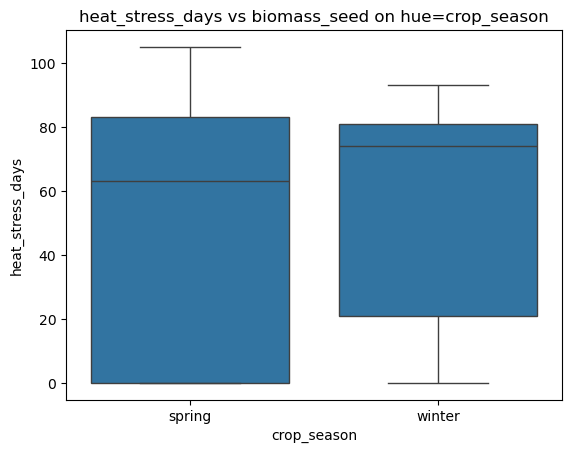

In [82]:
# It might be interesting to look at heat stress days on different season
sns.boxplot(x='crop_season', y='heat_stress_days', data=df)
plt.title('heat_stress_days vs biomass_seed on hue=crop_season')
plt.show()

In [83]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).drop('biomass_seed', axis=1).columns

In [84]:
from sklearn.model_selection import train_test_split

# get target variable(biomass_seed)
X = df.drop(['biomass_seed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<Axes: xlabel='biomass_seed', ylabel='Count'>

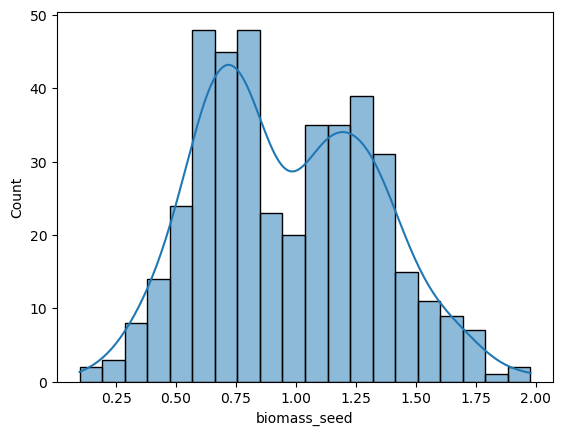

In [85]:
# see distribution of y_train
sns.histplot(y_train, bins=20, kde=True)

In [86]:
# function to prepare featuers for training
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def prepare_features(train_features, categorical, numerical):
    # Define transformers
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
    numerical_transformer = SimpleImputer(strategy='median')
    
    # Create column transformer
    preprocessor = ColumnTransformer(
      transformers=[
        ('cat', categorical_transformer, categorical),
        ('num', numerical_transformer, numerical)
      ])
  
    # Fit and transform training data
    X_train_prepared = preprocessor.fit_transform(train_features)
    
    return X_train_prepared, preprocessor

def transform_features(features, preprocessor):
  # Transform new data (e.g., test set) with fitted preprocessor
  X_prepared = preprocessor.transform(features)
  return X_prepared

X_train_prepared, preprocessor = prepare_features(X_train, categorical_columns, numerical_columns)
X_test_prepared = transform_features(X_test, preprocessor)

In [87]:
def get_feature_names(column_transformer):
    # For sklearn >=1.0, ColumnTransformer has get_feature_names_out
    # But it doesn't always handle nested transformers perfectly, so we do this:

    feature_names = []

    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            # if you set remainder='passthrough' then handle here
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            # e.g., OneHotEncoder
            names = transformer.get_feature_names_out(cols)
        else:
            # e.g., SimpleImputer, just keep original column names
            names = cols
        feature_names.extend(names)

    return feature_names

# Usage:
feature_names = get_feature_names(preprocessor)

In [88]:
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=feature_names, index=X_train.index)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=feature_names, index=X_test.index)

In [89]:
# train xgb on plant_density for feature_importances with shap
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train_prepared, y_train);

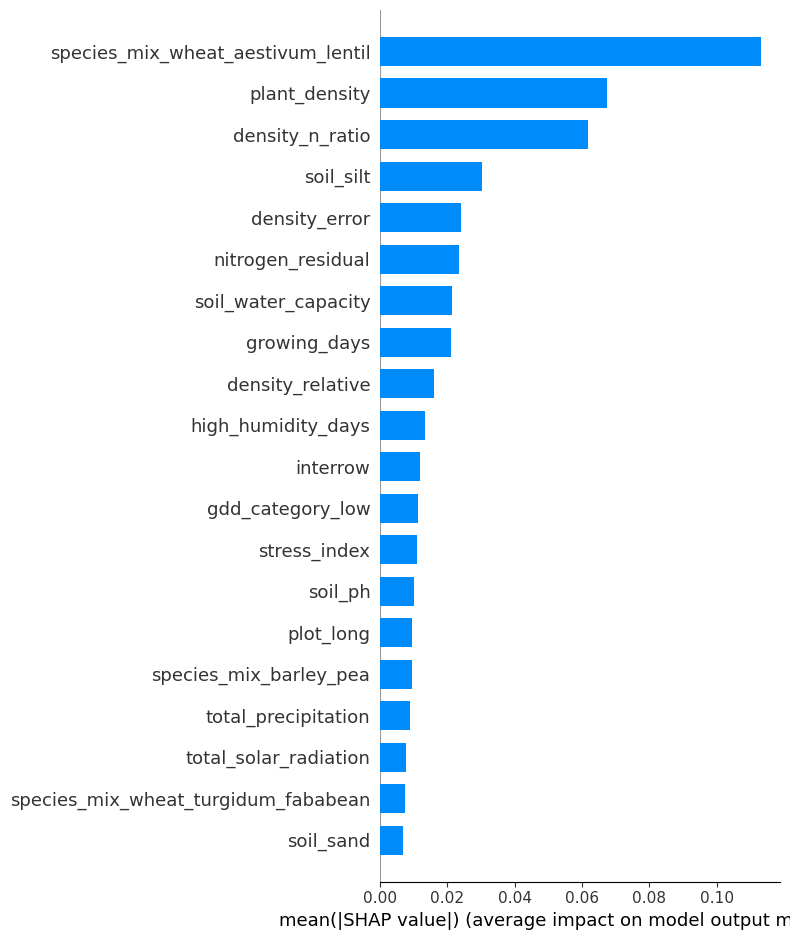

In [90]:
# shap
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_prepared_df)
shap.summary_plot(shap_values, X_train_prepared_df, plot_type="bar")

In [91]:
# predict on test set with r2 and rmse
from sklearn.metrics import r2_score, mean_squared_error

# revert the log1p transformation
y_pred = xgb_model.predict(X_test_prepared_df)

y_pred = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

r2 = r2_score(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"R2: {r2}")
print(f"RMSE: {rmse}")

R2: 0.7634304101834313
RMSE: 0.6142809430431652


In [92]:
# for col in X_train_prepared_df.columns:
#   print(f"{col}: {xgb_model.feature_importances_[feature_names.index(col)]}")

In [93]:
# i will try training on top shap features to see how well they can predict
# Top 5-10 SHAP features + domain-important columns (e.g., soil, climate)
top_features = [
  'species_mix_wheat_aestivum_lentil',
  'density_n_ratio',                    
  'plant_density',                      
  'soil_water_capacity',                
  'density_error',                      
  'nitrogen_residual',
  'total_precipitation',                             # Soil critical
  'n_amount',                           # Agronomic critical
  'growing_days',                       # Temporal control
  'stress_index',                       # Stress indicator
]

domain_important_features = [
  'soil_ph',                          # soil quality
  'soil_awc',
  'irrigation_amount',                # Water
  'GDD',
  'high_humidity_days',
  'heat_stress_days',                   # Heat stress
  'crop_season_winter',                 
]

new_top_features = top_features + domain_important_features

X_train_top = X_train_prepared_df[new_top_features]
X_test_top = X_test_prepared_df[new_top_features]

# retrain XGBoost on top features
xgb_model_top = XGBRegressor(random_state=42).fit(X_train_top, y_train)

# predict on test set
y_pred_full = np.expm1(xgb_model.predict(X_test_prepared_df))
y_pred_top = np.expm1(xgb_model_top.predict(X_test_prepared_df[new_top_features]))

# compare R² and RMSE
r2_full = r2_score(y_test_original, y_pred_full)
r2_top = r2_score(y_test_original, y_pred_top)
rmse_top = np.sqrt(mean_squared_error(y_test_original, y_pred_top))

print(f"Full features R²: {r2_full:.3f}")
print(f"Top features R²: {r2_top:.3f}")
print(f"Top features RMSE: {rmse_top:.3f}")


Full features R²: 0.763
Top features R²: 0.753
Top features RMSE: 0.627


In [244]:
from scipy.stats import ttest_rel

# Bootstrap R² differences (5000 samples)
# Initialize score lists
full_scores = []
top_scores = []
np.random.seed(42)  # For reproducibility
for _ in range(5000):
    sample_idx = np.random.choice(len(y_test_original), len(y_test_original), replace=True)
    
    # Full model prediction
    y_pred_full = xgb_model.predict(X_test_prepared_df.iloc[sample_idx])
    y_pred_full = np.expm1(y_pred_full)
    full_scores.append(r2_score(y_test_original.iloc[sample_idx], y_pred_full))
    
    # Top-feature model prediction
    y_pred_top = xgb_model_top.predict(X_test_prepared_df[new_top_features].iloc[sample_idx])
    y_pred_top = np.expm1(y_pred_top)
    top_scores.append(r2_score(y_test_original.iloc[sample_idx], y_pred_top))

# Paired t-test
t_stat, p_value = ttest_rel(full_scores, top_scores)
print(f"p-value: {p_value:.4f}")  # If > 0.05, difference is not significant

p-value: 0.0000


The p-value of zero on the baseline models suggest that the difference between them is statistically significant. However, we'll still be sticking with the top-features to keep the model simple and avoid overfitting. This decision is brought by the negligble difference in r2.

## Looking in to the top features after tuning

In [107]:
training_features = top_features + domain_important_features

good: bool = True
for feature in training_features:
  if feature not in X_test_prepared_df.columns:
    print(f"{feature} not in X_train_prepared_df")
    good = False

if good:
  print("All features are present in X_train_prepared_df")
else:
  print("Not all features are present in X_train_prepared_df")

All features are present in X_train_prepared_df


In [108]:
# loading here the fine tuned model
xgb_model = XGBRegressor()
xgb_model.load_model("final_model.bin")

In [109]:
# Using here the combined full dataset and splitting it in Kfold so it can make use of more data.

# combine X_train_top and X_test_top
combined_df = pd.concat([X_train_top, X_test_top], axis=0)

# combine tests
y_test_combined = pd.concat([y_train, y_test], axis=0)

In [110]:
# use k-fold to validate final model
from sklearn.model_selection import KFold
# use final_model_params.json
params = {
    "objective": "reg:squarederror",
    "colsample_bylevel": 0.9556787811383483,
    "colsample_bytree": 0.9189038694956897,
    "gamma": 0.0029143197332355173,
    "learning_rate": 0.025092557876503722,
    "max_depth": 6,
    "min_child_weight": 7,
    "n_estimators": 800,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 0.00317929504532371,
    "reg_lambda": 1.233909528803232,
    "subsample": 0.9681813389671091,
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []


for train_index, test_index in kf.split(combined_df):
    X_train_fold, X_test_fold = combined_df.iloc[train_index], combined_df.iloc[test_index]
    y_train_fold, y_test_fold = y_test_combined.iloc[train_index], y_test_combined.iloc[test_index]

    model = XGBRegressor(**params)
    model.fit(X_train_fold, y_train_fold)
    y_pred = np.expm1(model.predict(X_test_fold))
    y_true = np.expm1(y_test_fold)
    score = r2_score(y_true, y_pred)
    scores.append(score)

print(f"Mean R²: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")

Mean R²: 0.6793
Standard Deviation: 0.1479


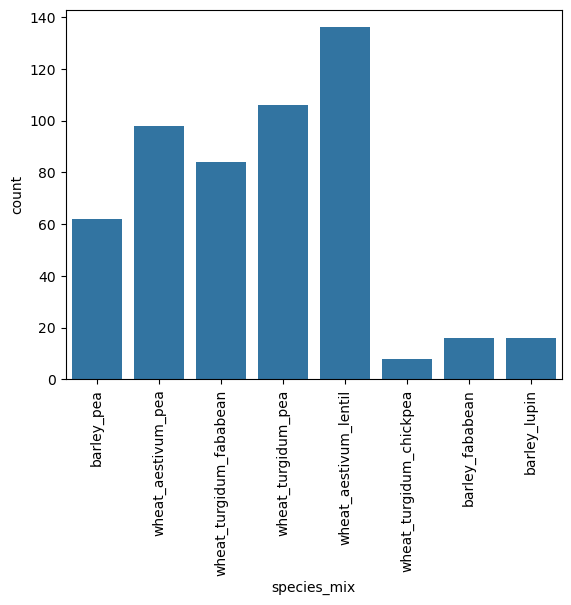

In [111]:
# look at the distribution of species_mix
sns.countplot(x='species_mix', data=df)
plt.xticks(rotation=90)
plt.show()

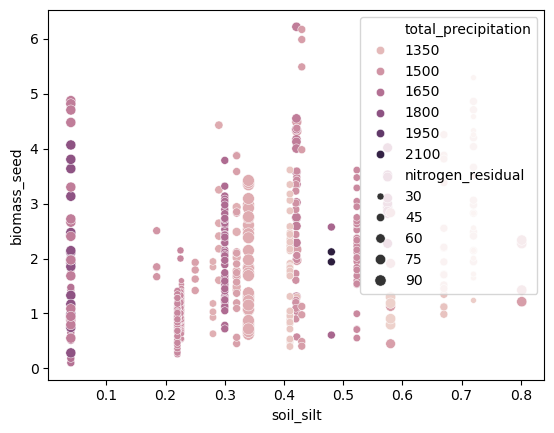

In [112]:
# Check if silt interacts with other features
sns.scatterplot(data=df, x='soil_silt', y='biomass_seed', 
  hue='total_precipitation', size='nitrogen_residual');

/tmp/ipykernel_12459/2695672300.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby('density_n_ratio_bin')['biomass_seed'].mean().plot(kind='bar')


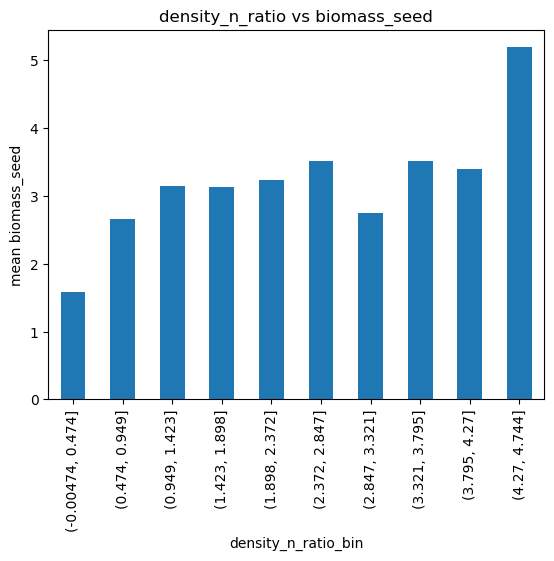

In [113]:
# Find the ratio that maximizes yield
import numpy as np
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['density_n_ratio', 'biomass_seed'])
df_clean['density_n_ratio_bin'] = pd.cut(df_clean['density_n_ratio'], bins=10)
df_clean.groupby('density_n_ratio_bin')['biomass_seed'].mean().plot(kind='bar')
plt.ylabel('mean biomass_seed')
plt.title('density_n_ratio vs biomass_seed')
plt.show();

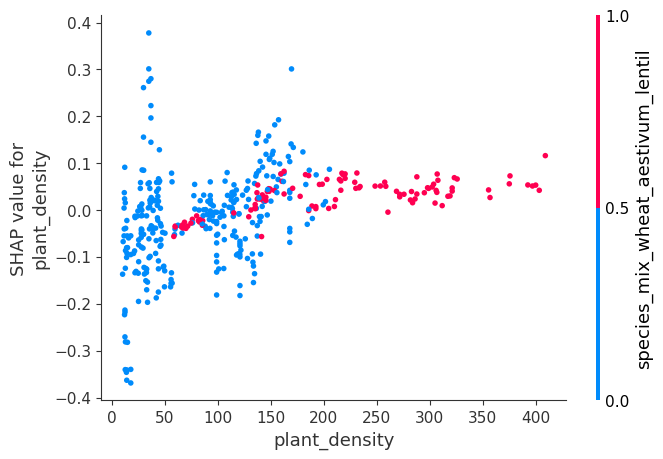

In [114]:
# How plant_density's effect changes with other features
shap.dependence_plot(
  ind='plant_density', 
  shap_values=shap_values, 
  features=X_train_prepared_df,
  interaction_index='species_mix_wheat_aestivum_lentil'
)

You may be wondering what the Y-axis is. It is how much plant_density contributes to the prediction (positive means it increases predicted yield, negative means it decreases).(Thanks gpt)

The graph suggests that after some value of plant density, it doesn't increase the predicted yield.

In [117]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_top)

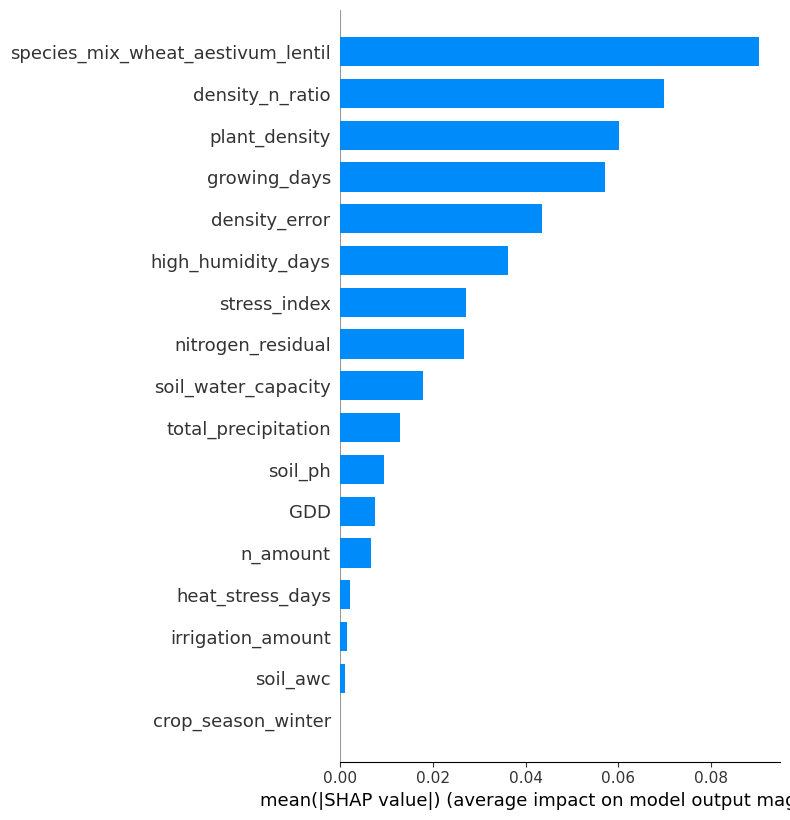

In [118]:
# shap.summary_plot(shap_values, X_test_prepared_df[training_features], plot_type="bar")
shap.summary_plot(shap_values, X_train_top, plot_type="bar")

That specific mix seems to be very successful!

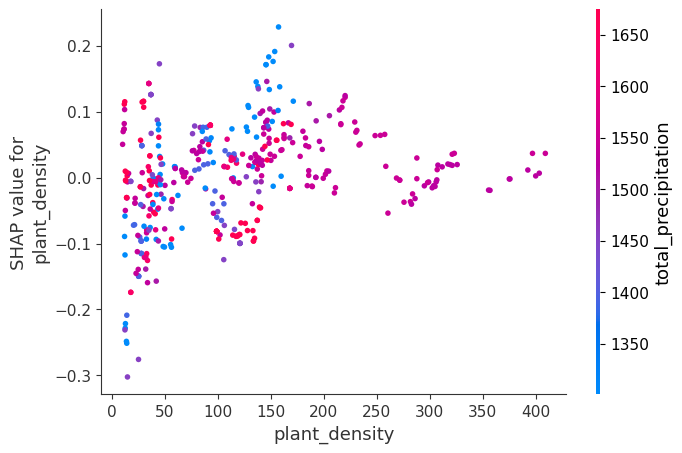

In [120]:
shap.dependence_plot("plant_density", shap_values, X_train_top)

It starts low, then as plant_density increases, chances are yield will increase but reaches a certain cap.

Diminishing Returns Beyond 200 Plants/m²:
- From ~200 to 400 plants/m², SHAP values converge near zero or remain slightly positive.
- This implies increasing plant density beyond this point yields little added benefit or influence on the model’s target prediction.

Initially (0–100 plants/m²), the impact on the model prediction is both positive and negative, suggesting sensitivity to context (e.g., weather, soil).

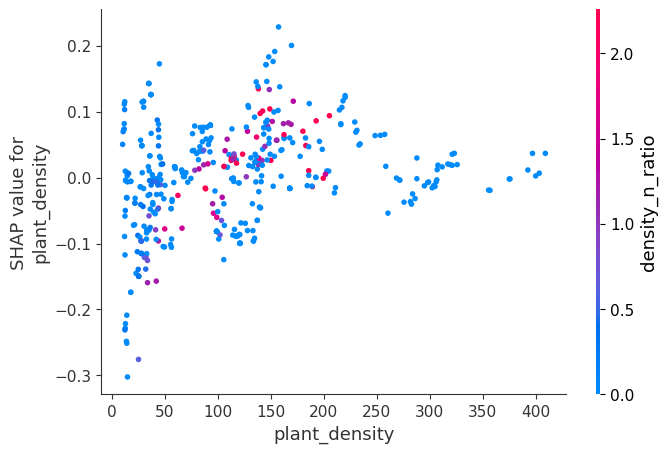

In [122]:
shap.dependence_plot(
    "plant_density", 
    shap_values, 
    X_train_top,
    interaction_index="density_n_ratio"
)

SHAP Impact Still Peaks Around 150–200:
- As in the previous plot, SHAP values for plant_density are most positive around this range.
- Suggests this is a generally optimal density regardless of the nitrogen context.

Looking at high density_n_ratio, it seems to lean towards positive SHAP, but the amount of data doesn't make it conclusive

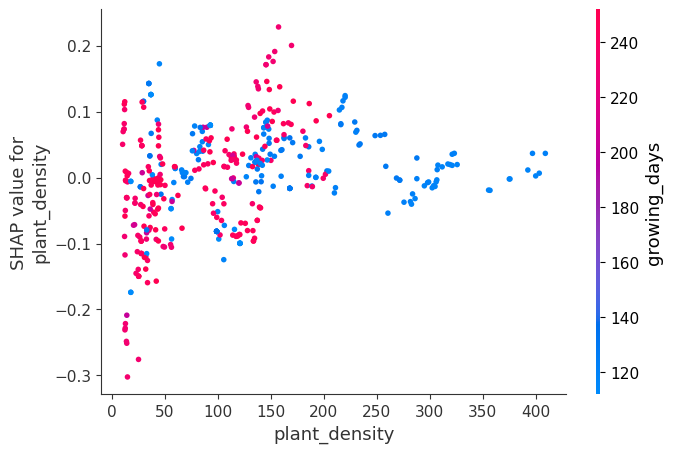

In [128]:
shap.dependence_plot(
    "plant_density", 
    shap_values, 
    X_train_top,
    interaction_index="growing_days"
)

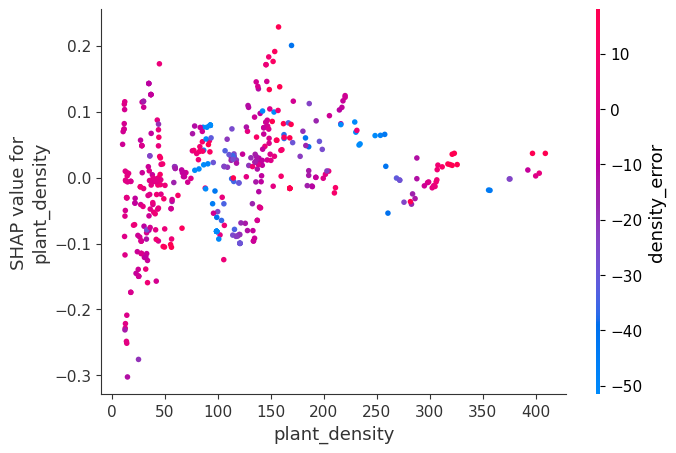

In [125]:
shap.dependence_plot(
    "plant_density", 
    shap_values, 
    X_train_top,
    interaction_index="density_error"
)

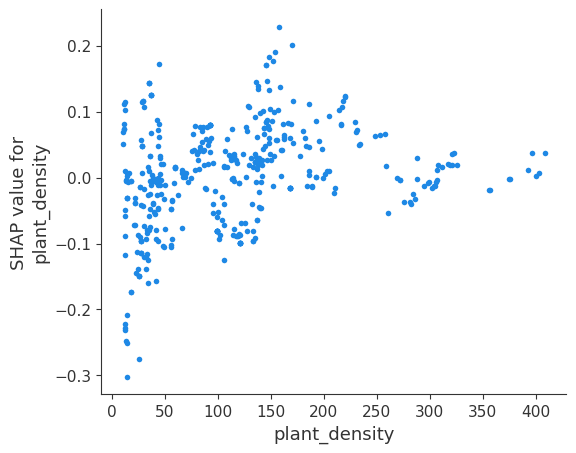

In [133]:
shap.dependence_plot(
    "plant_density", 
    shap_values, 
    X_train_top,
    interaction_index=None
)

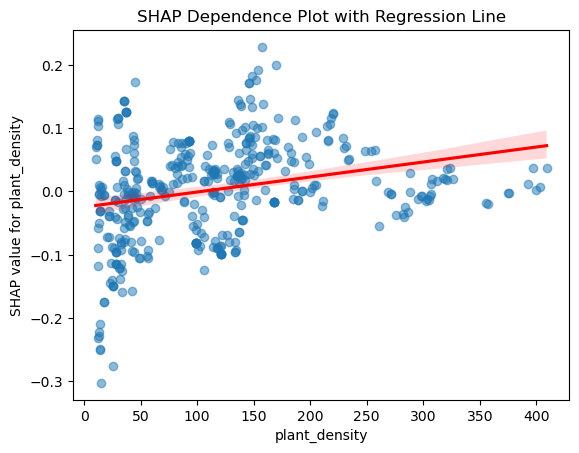

In [131]:
x = X_train_top["plant_density"].values
y = shap_values[:, X_train_top.columns.get_loc("plant_density")]

sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("plant_density")
plt.ylabel("SHAP value for plant_density")
plt.title("SHAP Dependence Plot with Regression Line")
plt.show()